АНАЛИЗ ЧАСТОТЫ ОТКЛЮЧЕНИЙ ПО ТИПАМ

РЕЗУЛЬТАТЫ:
       type  total_outages        first_outage         last_outage
  hot_water           9339 2018-01-01 10:44:00 2019-12-31 15:01:00
 cold_water           9109 2018-01-01 00:24:00 2019-12-31 10:54:00
electricity           4745 2018-01-01 00:08:00 2019-12-31 20:29:00
       heat           2071 2018-01-01 11:50:00 2019-12-31 15:01:00

КЛЮЧЕВЫЕ ИНСАЙТЫ:
HOT_WATER: 9339 отключений
Период: 2018-01-01 - 2019-12-31

COLD_WATER: 9109 отключений
Период: 2018-01-01 - 2019-12-31

ELECTRICITY: 4745 отключений
Период: 2018-01-01 - 2019-12-31

HEAT: 2071 отключений
Период: 2018-01-01 - 2019-12-31



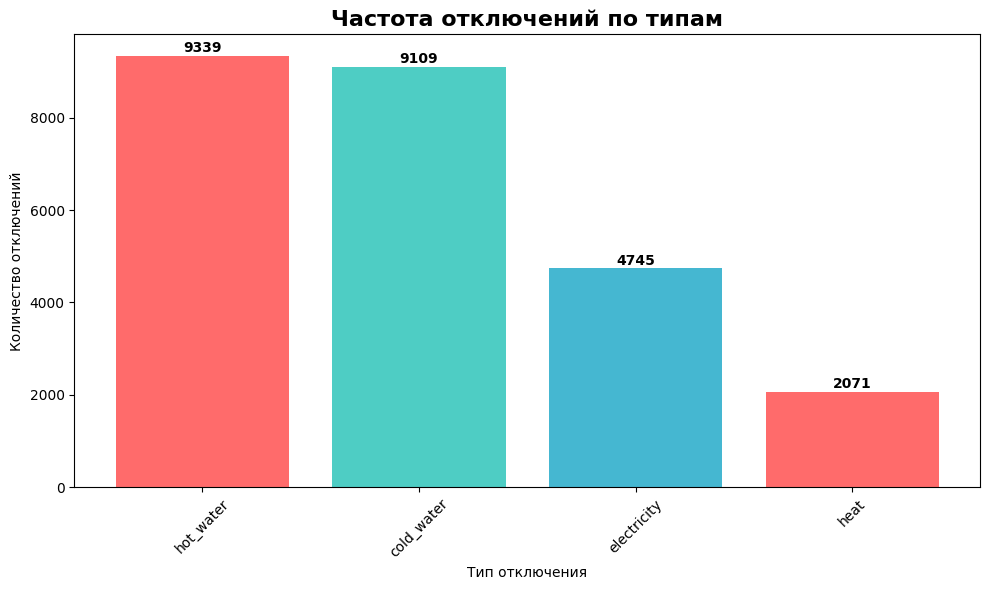


Сохранено:
- outages_frequency.csv
- outages_frequency.png


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Настройка графиков (БЕЗ эмодзи!)
plt.rcParams['figure.figsize'] = (10, 6)

def analyze_outages_frequency(db_path='../databases/dataset.db'):
    """Анализ частоты отключений по типам"""
    
    conn = sqlite3.connect(db_path)
    
    print("АНАЛИЗ ЧАСТОТЫ ОТКЛЮЧЕНИЙ ПО ТИПАМ")
    print("="*40)
    
    # ПРОСТОЙ ЗАПРОС
    query = """
    SELECT 
        type,
        COUNT(*) as total_outages,
        MIN(start_date) as first_outage,
        MAX(start_date) as last_outage
    FROM blackouts 
    WHERE start_date IS NOT NULL
    GROUP BY type
    ORDER BY total_outages DESC
    """
    
    simple_query = """
    SELECT type, COUNT(*) as cnt 
    FROM blackouts 
    GROUP BY type 
    ORDER BY cnt DESC
    """
    
    try:
        # ВЫПОЛНЕНИЕ
        df = pd.read_sql_query(query, conn)
        df_simple = pd.read_sql_query(simple_query, conn)
        
        # ТАБЛИЦА
        print("\nРЕЗУЛЬТАТЫ:")
        print(df.to_string(index=False))
        
        # ИНСАЙТЫ (БЕЗ ПРИОРИТЕТА!)
        print("\nКЛЮЧЕВЫЕ ИНСАЙТЫ:")
        for idx, row in df.iterrows():
            print(f"{row['type'].upper()}: {row['total_outages']} отключений")
            print(f"Период: {row['first_outage'][:10]} - {row['last_outage'][:10]}")
            print()
        
        # ГРАФИК (БЕЗ ЭМОДЗИ!)
        plt.figure(figsize=(10, 6))
        bars = plt.bar(df_simple['type'], df_simple['cnt'], 
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        plt.title('Частота отключений по типам', fontsize=16, fontweight='bold')
        plt.ylabel('Количество отключений')
        plt.xlabel('Тип отключения')
        plt.xticks(rotation=45)
        
        # Подписи
        for bar, count in zip(bars, df_simple['cnt']):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 10,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('outages_frequency.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # ЭКСПОРТ
        df.to_csv('outages_frequency.csv', index=False, encoding='utf-8')
        print(f"\nСохранено:")
        print(f"- outages_frequency.csv")
        print(f"- outages_frequency.png")
        
    except Exception as e:
        print(f"Ошибка: {e}")
    
    finally:
        conn.close()

if __name__ == "__main__":
    analyze_outages_frequency('../databases/dataset.db')

In [15]:
import sqlite3
from collections import defaultdict

# Словарь для преобразования номера месяца в название на русском
month_names = {
    '01': 'Январь', '02': 'Февраль', '03': 'Март', '04': 'Апрель',
    '05': 'Май', '06': 'Июнь', '07': 'Июль', '08': 'Август',
    '09': 'Сентябрь', '10': 'Октябрь', '11': 'Ноябрь', '12': 'Декабрь'
}

# Подключение к базе данных
conn = sqlite3.connect('../databases/dataset.db')
cursor = conn.cursor()

# SQL-запрос для выборки отключений с типом 'heat'
query = """
SELECT strftime('%Y-%m', start_date) AS month
FROM blackouts
WHERE type = 'heat'
"""

# Выполнение запроса
cursor.execute(query)

# Подсчет отключений по месяцам
monthly_counts = defaultdict(int)
for row in cursor.fetchall():
    month = row[0]  # Получаем год-месяц (YYYY-MM)
    monthly_counts[month] += 1

# Закрытие соединения
conn.close()

# Вывод результатов
print("Месяц          | Кол-во отключений")
print("---------------|------------------")
for month, count in sorted(monthly_counts.items()):
    year, month_num = month.split('-')  # Разделяем YYYY-MM на год и месяц
    month_name = month_names.get(month_num, month_num)  # Получаем название месяца
    print(f"{month_name} {year} | {count}")

Месяц          | Кол-во отключений
---------------|------------------
Январь 2018 | 174
Февраль 2018 | 136
Март 2018 | 94
Апрель 2018 | 146
Ноябрь 2018 | 242
Декабрь 2018 | 239
Январь 2019 | 192
Февраль 2019 | 203
Март 2019 | 135
Апрель 2019 | 182
Май 2019 | 9
Ноябрь 2019 | 142
Декабрь 2019 | 177


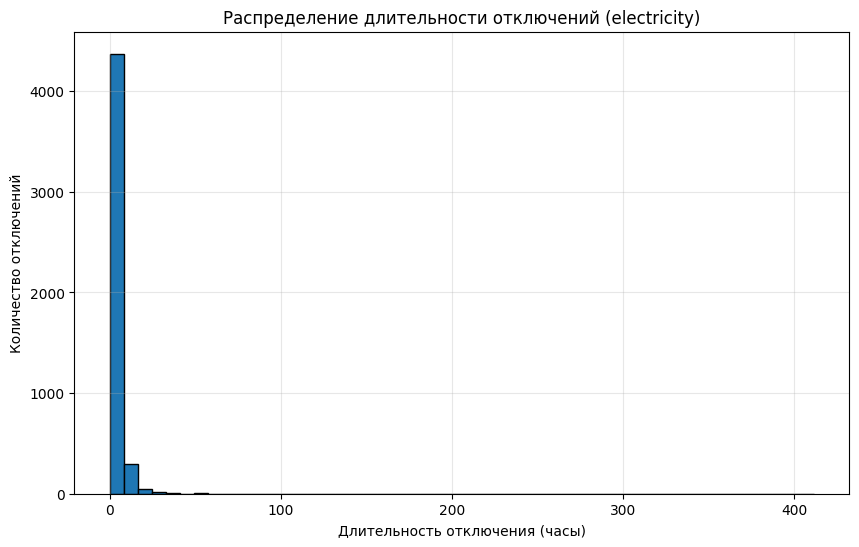

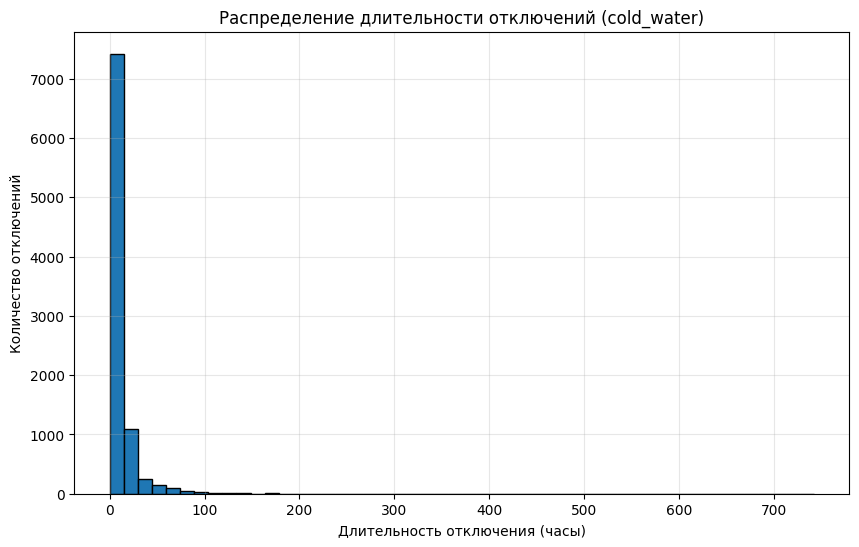

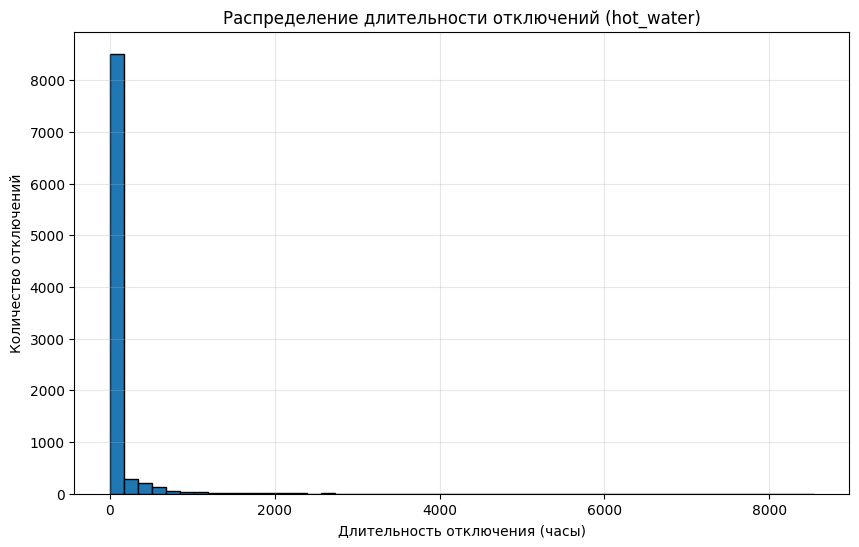

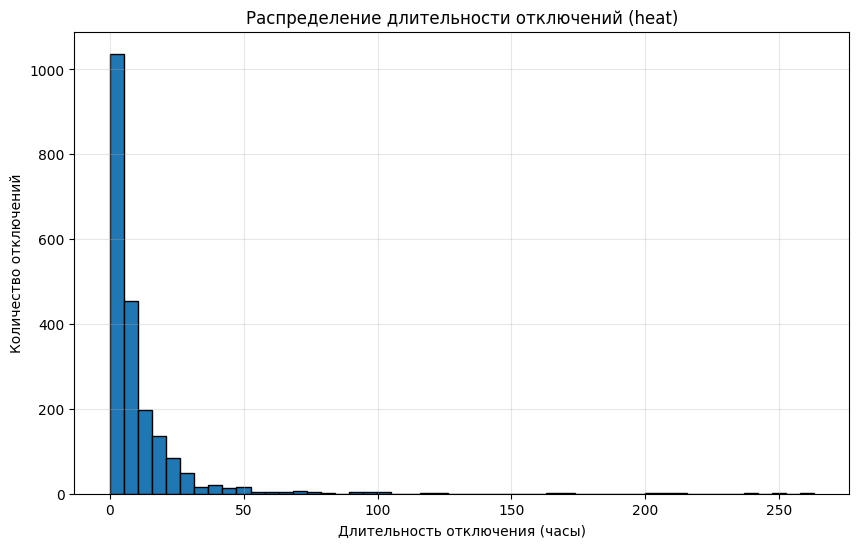

Все графики отображены.


In [20]:
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
import numpy as np

# Подключение к базе данных
conn = sqlite3.connect('../databases/dataset.db')
cursor = conn.cursor()

# Получение всех уникальных типов отключений
cursor.execute("SELECT DISTINCT type FROM blackouts")
types = [row[0] for row in cursor.fetchall()]

# Функция для вычисления длительности в часах
def calculate_duration_hours(start_date, end_date):
    try:
        start = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
        end = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
        duration = (end - start).total_seconds() / 3600  # Перевод в часы
        return duration if duration >= 0 else 0  # Игнорируем отрицательные длительности
    except ValueError:
        return None  # Пропускаем некорректные даты

# Сбор данных по каждому типу отключения
for blackout_type in types:
    # Запрос для получения start_date и end_date для текущего типа
    query = """
    SELECT start_date, end_date
    FROM blackouts
    WHERE type = ?
    """
    cursor.execute(query, (blackout_type,))
    
    # Список для хранения длительностей
    durations = []
    
    # Обработка данных
    for row in cursor.fetchall():
        start_date, end_date = row
        duration = calculate_duration_hours(start_date, end_date)
        if duration is not None:
            durations.append(duration)
    
    # Если данных нет, пропускаем тип
    if not durations:
        print(f"Нет данных для типа '{blackout_type}'")
        continue
    
    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    plt.hist(durations, bins=50, edgecolor='black', range=(0, max(48, max(durations))))
    plt.title(f'Распределение длительности отключений ({blackout_type})')
    plt.xlabel('Длительность отключения (часы)')
    plt.ylabel('Количество отключений')
    plt.grid(True, alpha=0.3)
    
    # Отображение графика
    plt.show()

# Закрытие соединения
conn.close()

print("Все графики отображены.")